# Testing MOCO methods
Systematic test of three moco methods for four GCaMP recordings

The results are compiled in a [slide deck](https://docs.google.com/presentation/d/1hsOjwFEZJ0azk5FJI2bkvqivIK1L_Az3B8AoM8sxfJ4/edit#slide=id.gf58d0edee0_0_0)

In [1]:
# imports (using the 'moco_repair' branch of GCE)
import time
import os
import json
import hashlib
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gcamp_extractor import MultiFileTiff
from gcamp_extractor.moco import compute_moco_offsets
from gcamp_extractor.moco import view_moco_offsets

In [33]:
# LOAD DATA

## test case worms, can be found on YAKALO NAS under /yakalo/share/jackson/
ykroot = '/media/gbubnis/Extreme SSD/yakalo/jackson'
root = ykroot+'/2021-07-21/worm15_act1'  # cat 2, some X drift
#root = ykroot+'/2021-07-30/worm04_act1'  # steady-ish X drift
#root = ykroot+'/2021-07-30/worm06_act1'  # nassty! head casting (rotation) and drift
#root = ykroot+'/2021-07-31/worm01_act1'  # still.. then X drift + joystick correction

params_mft = {
    'root':os.path.join(root, 'GCAMP'),
    'numz':12,
    'numc':1,
}

with open(os.path.join(root, 'info.json')) as f:
    infodict = json.load(f)

dwa = '%s_worm%02i_act%s' % (infodict['date'], int(infodict['worm']), infodict['act'])
print(dwa)

# GROUND TRUTH: cumulative X,Y offsets for first 500 vols
ground_truth = {
    '2021-07-21_worm15_act1':[-32, -2],
    '2021-07-30_worm04_act1':[-108, 0],
    '2021-07-30_worm06_act1':[180, -10],
    '2021-07-31_worm01_act1':[228, 18], # still some visible jitter for some frames
}

output_dir = os.path.join('mocotest_'+ dwa)
os.makedirs(output_dir, exist_ok=True)
mft = MultiFileTiff(output_dir=output_dir, **params_mft)

2021-07-31_worm01_act1


In [34]:
# make param dicts

qq = 0
stride = 10
p0 = dict(stride=stride, mode_2D='mid', quantile=qq, median=0, gaussian=0, method='ird', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p1 = dict(stride=stride, mode_2D='mid', quantile=qq, median=3, gaussian=0, method='ird', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p2 = dict(stride=stride, mode_2D='mid', quantile=qq, median=5, gaussian=0, method='ird', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p3 = dict(stride=stride, mode_2D='mid', quantile=qq, median=5, gaussian=2, method='ird', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p4 = dict(stride=stride, mode_2D='mid', quantile=qq, median=5, gaussian=4, method='ird', ird_filter_pcorr=0, upsample_factor=0, t_max=500)

p5 = dict(stride=stride, mode_2D='mid', quantile=qq, median=0, gaussian=0, method='skimage', ird_filter_pcorr=0, upsample_factor=10, t_max=500)
p6 = dict(stride=stride, mode_2D='mid', quantile=qq, median=3, gaussian=0, method='skimage', ird_filter_pcorr=0, upsample_factor=10, t_max=500)
p7 = dict(stride=stride, mode_2D='mid', quantile=qq, median=5, gaussian=0, method='skimage', ird_filter_pcorr=0, upsample_factor=10, t_max=500)
p8 = dict(stride=stride, mode_2D='mid', quantile=qq, median=5, gaussian=2, method='skimage', ird_filter_pcorr=0, upsample_factor=10, t_max=500)
p9 = dict(stride=stride, mode_2D='mid', quantile=qq, median=5, gaussian=4, method='skimage', ird_filter_pcorr=0, upsample_factor=10, t_max=500)

p10 = dict(stride=stride, mode_2D='mid', quantile=0, median=0, gaussian=2, method='ipRLD', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p11 = dict(stride=stride, mode_2D='mid', quantile=0, median=3, gaussian=2, method='ipRLD', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p12 = dict(stride=stride, mode_2D='mid', quantile=0, median=5, gaussian=2, method='ipRLD', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p13 = dict(stride=stride, mode_2D='mid', quantile=0, median=3, gaussian=4, method='ipRLD', ird_filter_pcorr=0, upsample_factor=0, t_max=500)
p14 = dict(stride=stride, mode_2D='mid', quantile=0, median=5, gaussian=4, method='ipRLD', ird_filter_pcorr=0, upsample_factor=0, t_max=500)

todo = [p0, p1, p2, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14]
#todo = [p0, p1, p2, p5, p6, p7, p10, p11]
#todo = [p0test, p1test]

df_todo = pd.DataFrame(todo)
df_todo.head(20)

,stride,mode_2D,quantile,median,gaussian,method,ird_filter_pcorr,upsample_factor,t_max
0,10,mid,0,0,0,ird,0,0,500
1,10,mid,0,3,0,ird,0,0,500
2,10,mid,0,5,0,ird,0,0,500
3,10,mid,0,0,0,skimage,0,10,500
4,10,mid,0,3,0,skimage,0,10,500
5,10,mid,0,5,0,skimage,0,10,500
6,10,mid,0,5,2,skimage,0,10,500
7,10,mid,0,5,4,skimage,0,10,500
8,10,mid,0,0,2,ipRLD,0,0,500
9,10,mid,0,3,2,ipRLD,0,0,500


In [35]:
# compute offsets and dump to file, allowing re-load to avoid slow re-compute
#force = True
force = False

def get_offsets(mft, params):
    """pack up params and compute offsets"""
    filter_keys = ['quantile', 'median', 'gaussian']
    other_keys = ['method', 'ird_filter_pcorr', 'upsample_factor', 't_max', 'mode_2D', 'stride']
    flt = {k:params[k] for k in filter_keys}
    oth = {k:params[k] for k in other_keys}
    offsets = compute_moco_offsets(mft=mft, filter_params=flt, **oth)
    return offsets

all_offsets = []
all_errors = []
for p in todo:
    # hash the params+data source to get a unique filename for the computed offset 
    xxx = json.dumps(p, sort_keys=True)+root
    hash8 = hashlib.sha224(str(xxx).encode('utf-8')).hexdigest()[-8:]
    datafile = os.path.join(output_dir, 'data-%s.pk' % hash8)

    tag = 'med/gauss/method/file: %-18s %s' % (str([p['median'], p['gaussian'], p['method']]),  datafile)
    if not os.path.isfile(datafile) or force:
        # not yet run run
        print('calc:', tag)
        t00 = time.time()
        offsets = get_offsets(mft, p)
        t01 = time.time()
        print('runtime [s]:', (t01-t00)//1)
        file_pi = open(datafile, 'wb')
        pickle.dump([p, offsets], file_pi)
        file_pi.close()
    else:
        # already run
        print('load:', tag)
        with open(datafile,'rb') as f:
            [p, offsets] = pickle.load(f)

    # distance from GT
    xyz_moco = -np.flipud(np.sum(offsets, axis=0)[1:3])
    xyz_gt = ground_truth[dwa]
    error = np.linalg.norm(xyz_moco-xyz_gt)//1

    all_errors.append(error)
    all_offsets.append(offsets)
df_todo['error'] = all_errors
df_todo['worm'] = [dwa]*len(all_errors)

load: med/gauss/method/file: [0, 0, 'ird']      mocotest_2021-07-31_worm01_act1/data-9289bfe2.pk
load: med/gauss/method/file: [3, 0, 'ird']      mocotest_2021-07-31_worm01_act1/data-26532769.pk
load: med/gauss/method/file: [5, 0, 'ird']      mocotest_2021-07-31_worm01_act1/data-91f7008c.pk
load: med/gauss/method/file: [0, 0, 'skimage']  mocotest_2021-07-31_worm01_act1/data-e524eaef.pk
load: med/gauss/method/file: [3, 0, 'skimage']  mocotest_2021-07-31_worm01_act1/data-00ed7164.pk
load: med/gauss/method/file: [5, 0, 'skimage']  mocotest_2021-07-31_worm01_act1/data-6e0ccfe1.pk
load: med/gauss/method/file: [5, 2, 'skimage']  mocotest_2021-07-31_worm01_act1/data-b7ad6a94.pk
load: med/gauss/method/file: [5, 4, 'skimage']  mocotest_2021-07-31_worm01_act1/data-6961095a.pk
load: med/gauss/method/file: [0, 2, 'ipRLD']    mocotest_2021-07-31_worm01_act1/data-d50cbf2e.pk
load: med/gauss/method/file: [3, 2, 'ipRLD']    mocotest_2021-07-31_worm01_act1/data-8de72571.pk
load: med/gauss/method/file: [

In [36]:
df_todo.head(20)

,stride,mode_2D,quantile,median,gaussian,method,ird_filter_pcorr,upsample_factor,t_max,error,worm
0,10,mid,0,0,0,ird,0,0,500,228.0,2021-07-31_worm01_act1
1,10,mid,0,3,0,ird,0,0,500,101.0,2021-07-31_worm01_act1
2,10,mid,0,5,0,ird,0,0,500,10.0,2021-07-31_worm01_act1
3,10,mid,0,0,0,skimage,0,10,500,12.0,2021-07-31_worm01_act1
4,10,mid,0,3,0,skimage,0,10,500,10.0,2021-07-31_worm01_act1
5,10,mid,0,5,0,skimage,0,10,500,10.0,2021-07-31_worm01_act1
6,10,mid,0,5,2,skimage,0,10,500,9.0,2021-07-31_worm01_act1
7,10,mid,0,5,4,skimage,0,10,500,9.0,2021-07-31_worm01_act1
8,10,mid,0,0,2,ipRLD,0,0,500,11.0,2021-07-31_worm01_act1
9,10,mid,0,3,2,ipRLD,0,0,500,10.0,2021-07-31_worm01_act1


In [37]:
# Dump results to a csv that accumulates results
csv = os.path.join(output_dir, 'df_summary.csv')
if os.path.isfile(csv):
    df_old = pd.read_csv(csv, index_col=0)
    df_new = pd.concat((df_todo, df_old), axis=0).drop_duplicates().reset_index(drop=True)
else:
    df_new = df_todo

df_new = df_new[df_new['quantile'] == 0]
df_new.to_csv(csv)

df_sorted = df_new.sort_values(by='error')
csv = os.path.join(output_dir, 'df_summary_sorted.csv')
df_sorted.to_csv(csv)

#df_sorted.head(60)
df_new.head(60)


,stride,mode_2D,quantile,median,gaussian,method,ird_filter_pcorr,upsample_factor,t_max,error,worm
0,10,mid,0,0,0,ird,0,0,500,228.0,2021-07-31_worm01_act1
1,10,mid,0,3,0,ird,0,0,500,101.0,2021-07-31_worm01_act1
2,10,mid,0,5,0,ird,0,0,500,10.0,2021-07-31_worm01_act1
3,10,mid,0,0,0,skimage,0,10,500,12.0,2021-07-31_worm01_act1
4,10,mid,0,3,0,skimage,0,10,500,10.0,2021-07-31_worm01_act1
5,10,mid,0,5,0,skimage,0,10,500,10.0,2021-07-31_worm01_act1
6,10,mid,0,5,2,skimage,0,10,500,9.0,2021-07-31_worm01_act1
7,10,mid,0,5,4,skimage,0,10,500,9.0,2021-07-31_worm01_act1
8,10,mid,0,0,2,ipRLD,0,0,500,11.0,2021-07-31_worm01_act1
9,10,mid,0,3,2,ipRLD,0,0,500,10.0,2021-07-31_worm01_act1


0 -2.0 0.0
1 14.0 328.0
2 16.0 217.0
3 18.0 216.0
4 16.0 217.0
5 16.0 217.0
6 16.0 218.0
7 16.0 218.0
8 10.0 219.0
9 12.0 219.0
10 12.0 218.0
11 15.0 217.0
12 15.0 217.0
y stretch!


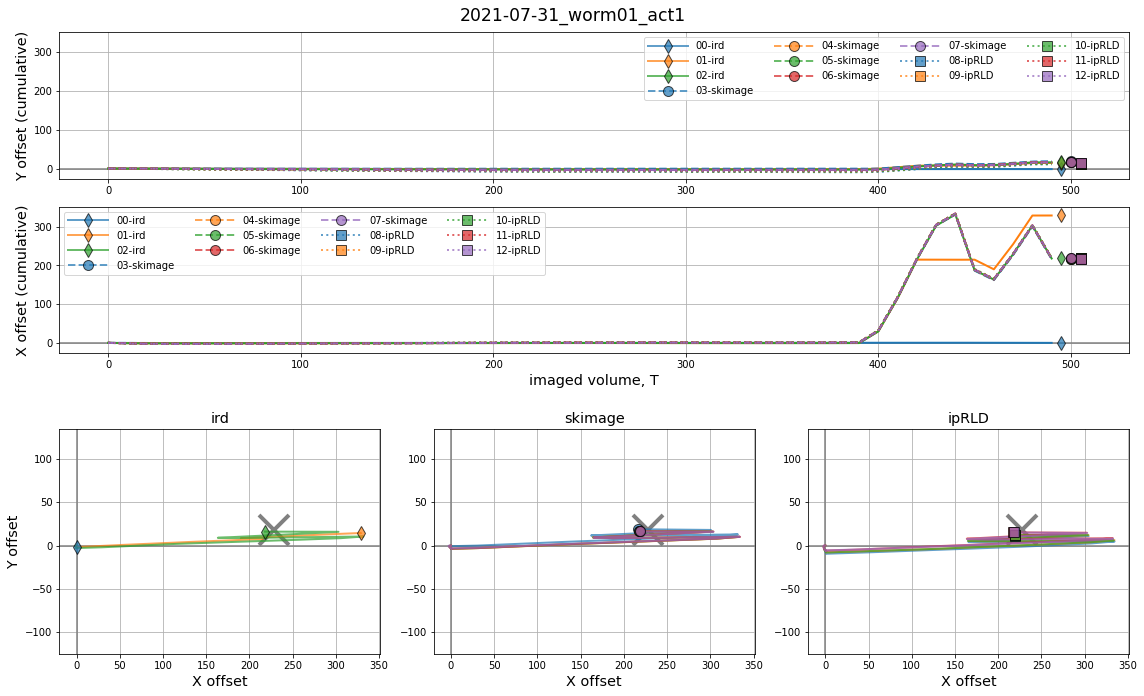

In [38]:
# plot offset timeseries
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']*10

fig = plt.figure(figsize=(16, 10))

axs = [plt.subplot(4,3,(1,3))]
axs.append(plt.subplot(4,3,(4,6), sharex=axs[0], sharey=axs[0]))
axs.append(plt.subplot(4,3,(7,10)))
axs.append(plt.subplot(4,3,(8,11), sharex=axs[2], sharey=axs[2]))
axs.append(plt.subplot(4,3,(9,12), sharex=axs[2], sharey=axs[2]))

axs[0].axhline(y=0, color='grey')
axs[1].axhline(y=0, color='grey')
axs[2].axhline(y=0, color='grey')
axs[2].axvline(x=0, color='grey')
axs[2].set_aspect('equal')
axs[3].axhline(y=0, color='grey')
axs[3].axvline(x=0, color='grey')
axs[3].set_aspect('equal')
axs[4].axhline(y=0, color='grey')
axs[4].axvline(x=0, color='grey')
axs[4].set_aspect('equal')


p['ird']     = dict(ls='-',  marker='d', _counter=0, panel2d=2, dt=5)
p['skimage'] = dict(ls='--', marker='o', _counter=0, panel2d=3, dt=10)
p['ipRLD']   = dict(ls=':',  marker='s', _counter=0, panel2d=4, dt=15)

# plot ground truth X markers
try:
    gtxy = ground_truth[dwa]
    axs[2].plot(gtxy[0], gtxy[1], 'x', color='k', mec='grey', mew=4, ms=30)
    axs[3].plot(gtxy[0], gtxy[1], 'x', color='k', mec='grey', mew=4, ms=30)
    axs[4].plot(gtxy[0], gtxy[1], 'x', color='k', mec='grey', mew=4, ms=30)
except:
    pass


for i, (params, offsets) in enumerate(zip(todo, all_offsets)):
    lbl = '%2.2i-%s' % (i, params['method'])
    tt = range(len(offsets))
    yy = np.cumsum(offsets[:,1])
    xx = np.cumsum(offsets[:,2])
    pp = p[params['method']]
    color = colors[pp['_counter']]

    # timeseries
    axs[0].plot(tt, -yy, ls=pp['ls'], color=color, lw=2)
    axs[1].plot(tt, -xx, ls=pp['ls'], color=color, lw=2)
    axs[0].plot(tt[-1]+pp['dt'], -yy[-1], marker=pp['marker'], ls=pp['ls'], color=color, mec='k', ms=10, lw=2, label=lbl, alpha=0.7)
    axs[1].plot(tt[-1]+pp['dt'], -xx[-1], marker=pp['marker'], ls=pp['ls'], color=color, mec='k', ms=10, lw=2, label=lbl, alpha=0.7)
    
    # 2d translation
    axs[pp['panel2d']].plot(-xx, -yy, label=lbl, color=color, lw=2, alpha=0.7)
    axs[pp['panel2d']].plot(-xx[-1], -yy[-1], marker=pp['marker'], ls=pp['ls'], color=color, mec='k', ms=10, lw=2, label=lbl, zorder=3, alpha=0.7)
    
    # color index counter
    pp['_counter'] += 1

    print(i, -yy[-1]//1, -xx[-1]//1)

# formatting        
axs[0].legend(fontsize='medium', ncol=4, handlelength=4)
axs[0].grid()
axs[0].set_ylabel('Y offset (cumulative)', fontsize='x-large')

axs[1].legend(fontsize='medium', ncol=4, handlelength=4)
axs[1].grid()
axs[1].set_ylabel('X offset (cumulative)', fontsize='x-large')
axs[1].set_xlabel('imaged volume, T', fontsize='x-large')

axs[2].set_xlabel('X offset', fontsize='x-large')
axs[2].set_ylabel('Y offset', fontsize='x-large')
axs[2].grid()
axs[2].set_title('ird', fontsize='x-large')

axs[3].set_xlabel('X offset', fontsize='x-large')
axs[3].grid()
axs[3].set_title('skimage', fontsize='x-large')

axs[4].set_xlabel('X offset', fontsize='x-large')
axs[4].grid()
axs[4].set_title('ipRLD', fontsize='x-large')


# stretch 2D plots if they are too flat
ylim = axs[2].get_ylim()
xlim = axs[2].get_xlim()
if np.diff(ylim)/np.diff(xlim)<0.7:
    print('y stretch!')
    dy = (np.diff(xlim)*0.7 - np.diff(ylim))/2
    axs[2].set_ylim((ylim[0]-dy, ylim[1]+dy))
    
fig.suptitle(dwa, fontsize='xx-large')
fig.tight_layout()

In [32]:
# view one case in napari (to decide what is closest to ground truth)
view_moco_offsets(mft, all_offsets[2])

In [ ]:
#np.linspace(0,4,4+1)[]

In [10]:
### SUMMARY PLOT
# after running a bunch of parameter configurations, plot all errors for all results
import glob
import itertools

### we group the data by three hierarchical categories
cat0 = 'worm'
cat1 = 'method'
cat2 = 'stride'

# load up all of the exported csv data
allcsv = glob.glob('mocotest_2021*/df_summary.csv')
df_all = pd.concat([pd.read_csv(f, index_col=0) for f in allcsv]).reset_index(drop=True)

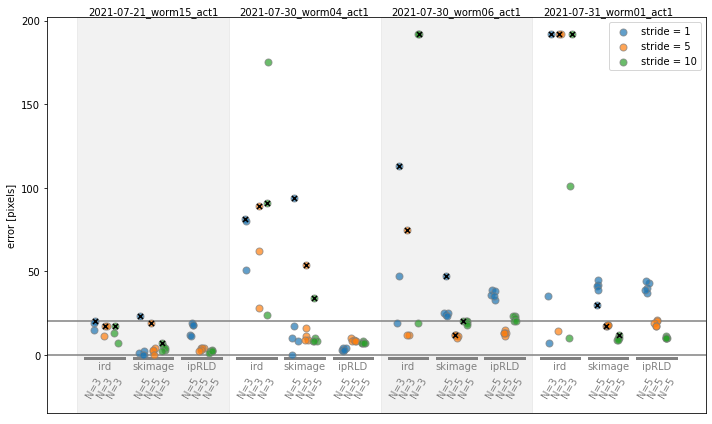

In [43]:
# PLOT SUMMARY

# i,j,k are indices for data categories 0,1,2
dxi = 22
dxj = 7
dxk = 1.5

ymin = -35
ymax = 202


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']*10
fig = plt.figure(figsize=(10, 6))
axs = [plt.subplot(1,1,1)]

axs[0].axhline(y=0, color='grey')
axs[0].axhline(y=20, color='grey')

X0 = sorted(df_all[cat0].unique())
X1 = df_all[cat1].unique()
X2 = df_all[cat2].unique()

getx = lambda i,j,k: i*dxi+j*dxj+k*dxk

ix = itertools.product(range(len(X0)), range(len(X1)), range(len(X2)))
keys = itertools.product(X0, X1, X2)
todo = list(zip(ix, keys))

ni = len(X0)
nj = len(X1)
nk = len(X2)

## i labels and j labels
for i in range(0, ni):
    xmid = getx(i,nj//2,nk//2)
    xa = xmid-dxi/2
    xb = xmid+dxi/2
    if i%2==0:
        axs[0].axvspan(xa, xb, color='grey', alpha=0.1)
    axs[0].text(xmid, ymax, X0[i], ha='center', va='bottom')

    # j labels
    for j in range(0, nj):
        xmid = getx(i, j, nk//2)
        xa = xmid-0.8*dxj/2
        xb = xmid+0.8*dxj/2
        axs[0].plot([xa, xb], [-2, -2], '-', color='grey', lw=3)
        axs[0].text(xmid, -4, X1[j], ha='center', va='top', color='grey')
    
## plot all of the errors
for (i,j,k), kk in todo:
    data = df_all[(df_all[cat0]==kk[0]) & (df_all[cat1]==kk[1]) & (df_all[cat2]==kk[2])].copy()
    xx = np.array([getx(i,j,k)]*len(data))
    yy = np.clip(data['error'], None, ymax-10)
    data['jitter'] = np.random.randn(len(data))*0.2
    jitter = data['jitter']

    if i == 0 and j == 0:
        lbl = '%s = %s' % (cat2, str(kk[2]))
    else:
        lbl = None
    axs[0].scatter(xx+jitter, yy, color=colors[k], edgecolors='grey', s=50, label=lbl, zorder=3, alpha=0.7)
    axs[0].text(xx[0], -12, 'N=%i' % len(data), ha='center', va='top', rotation=60, color='grey')

    # we want to single out the points with no filtering at all
    data_nofilter = data[(data['gaussian']==0) & (data['median']==0) & (data['quantile']==0)]
    xx = np.array([getx(i,j,k)]*len(data_nofilter))
    yy = np.clip(data_nofilter['error'], None, ymax-10)
    jitter = data_nofilter['jitter']
    axs[0].scatter(xx+jitter, yy, color='k', marker='x', s=25, zorder=3, alpha=1)

axs[0].set_ylim([ymin, ymax])
axs[0].set_ylabel('error [pixels]')
axs[0].legend()

_ = axs[0].set_xticklabels([])
_ = axs[0].set_xticks([])
plt.tight_layout()
plt.savefig('moco_results.png', dpi=150)